# CaseStudy_QuantitativeResearcher_TaiQuoc

## Overview

Since the portfolio constituents are already selected, the main focus is on weight optimization

Multiple aspects of index replication and model estimation are taken into account such as:

- Data quality

- Tracking error measurements: RMSE, Standard Deviation, Cumulative Return 

- Portfolio structure: Fixed weight or fixed shares

- Portfolio constraints: Positive weights, Sum to 100%

- Estimation objective: L1, L2, CVAR (Conditional value-at-risk) loss

- Regularization

- Rolling validation

To incorporate all these aspects in optimization, customized optimization algorithms are implemented and tested extensively

The final selected models are based on trade-off between model performance and model stability. While no information after Mar-2019 are used in model estimation (and selection), the final models show promising results in Apr-2019

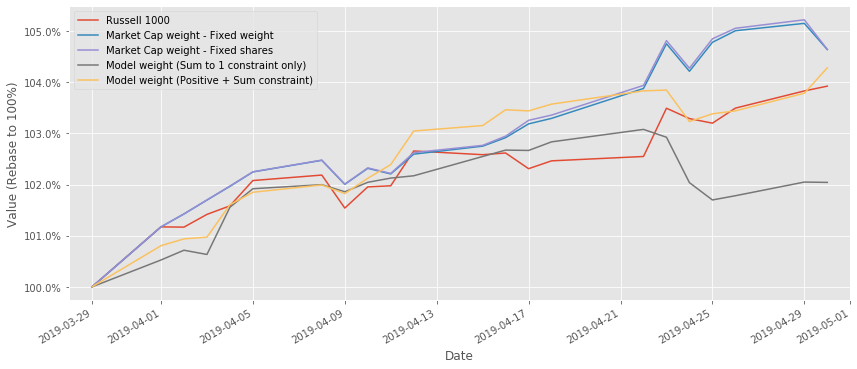

Tracking Error (Measurement definitions below):


,Market Cap - Fixed weight,Market Cap - Fixed shares,Model (Only sum to 1),Model (Positive + Sum to 1)
ETQ,0.006342,0.006610,0.006359,0.004161
MAD,0.002237,0.002281,0.003247,0.002564
RMSE,0.002901,0.002991,0.004283,0.003245
TESTD,0.002883,0.002973,0.004193,0.003241


In [60]:
############ Run code in CODE section below before running these code ############

temp_dict = dict()
temp_dict['Russell 1000'] = marketCap_TE_weight.get_level()[0]
temp_dict['Market Cap weight - Fixed weight']  = marketCap_TE_weight.get_level()[1]
temp_dict['Market Cap weight - Fixed shares']  = marketCap_TE_shares.get_level()[1]
temp_dict['Model weight (Sum to 1 constraint only)'] = final_models_dict['sum_1'][20]['validation-TE'].get_level()[1]
temp_dict['Model weight (Positive + Sum constraint)'] = final_models_dict['both'][20]['validation-TE'].get_level()[1]
temp_dict = pd.DataFrame(temp_dict, index=index_RUI.loc['03-29-2019':'04-2019'].index) * 100

fig, ax = plt.subplots(figsize=(14, 6))
temp_dict.plot(ax=ax)
ax.set_ylabel('Value (Rebase to 100%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
x1, x2 = ax.get_xlim()
plt.xlim(x1-1, x2+1) 
plt.legend()
plt.show()

temp_dict = dict()
temp_dict['Market Cap - Fixed weight']  = marketCap_TE_weight.get_TE()
temp_dict['Market Cap - Fixed shares']  = marketCap_TE_shares.get_TE()
temp_dict['Model (Only sum to 1)'] = final_models_dict['sum_1'][20]['validation-TE'].get_TE()
temp_dict['Model (Positive + Sum to 1)'] = final_models_dict['both'][20]['validation-TE'].get_TE()

print('Tracking Error (Measurement definitions below):')
display(pd.DataFrame(temp_dict))

## Reference

Most of the analysis are based on the Denis Karlow dissertation "Comparison and Development of Methods for Index Tracking" on 2012. This dissertation will hereby refer as Karlow, 2012. [The materials are available here](https://d-nb.info/1054242275/34) [or on my github](https://github.com/taiqm/Upload/blob/master/Karlow.pdf)

## Data

Prices and shares data are pulled from Yahoo Finance via yfinance/pandas_datareader packages

Russell 1000 constituents information are pulled from Norgate Data (https://norgatedata.com/)

Adjusted closed prices will be used for return calculation while closed prices will be used for market cap calculation (Yahoo closed prices already include split adjustment corporate actions but no dividend adjustment)

Data on daily frequency will be used in this research due to:

- The case study objective is to replicate daily closing

- Portfolio only has 25 assets so daily data provides enough samples without going to far back

- Higher frequency may contains more noise (Karlow, 2012 - Page 54)

Data period will be from July-2017 to Mar-2019 (since Russell rebalances on June annually and Norgate Data only available from 2018)

## Tracking Error measurements

Multiple different tracking error measurements are calculated as followed (Karlow, 2012 - Page 58, 59, 65):

- Tracking error (TE): $TE_{t} = R_{I, t} - R_{P, t}$

- Mean absolute difference (MAD): $MAD = \frac{1}{T}* \sum_{t = 1}^{T} |TE_{t}|$

- Root mean square error (RMSE): $RMSE = \sqrt{\frac{1}{T}* \sum_{t = 1}^{T} TE_{t}^{2}}$

- Expost tracking quality (ETQ): $ETQ = \frac{1}{T} * \sum_{t = 1}^{T} |R_{I, t}^{c} - R_{P, t}^{c}|$. With $R_{t}^{c}$ is compound return up to time t 

## Portfolio structure

Both fixed weight and fixed shares portfolio structure are incoporated in the model selection framework

However due to fixed shares optimization cannot be solved by the solver directly, an adjustment method is applied on return to transform variable weight (i.e fixed shares) to fixed weight (Karlow, 2012 - Page 72)

The adjustment method (Karlow, 2012 - Page 75): <img src="correction_EOP.png" style="width: 500px;">

## Portfolio constraints

There are two constraints considered:

- All weights sum to 100%

- All weights positive

The weight sum constraint is always enforced while positive weights constraint can be relaxed (Allow short sell)

## Estimation objective

There are 3 different loss objectives are considered for model estimation:

- L1 loss: Minimize MAD

- L2 loss: Minimize RMSE

- CVAR loss: Minimize Conditional value-at-risk

<img src="CVAR_loss.png" style="width: 350px;">

## Regularization

To avoid overfitting and increase model generalization ability, regularization term is added in estimation

Due to weight sum constraint (and positive constraint), LASSO and Elastic-net are not suitable for regularization here

Therefore, Ridge regularization term is added. Regularized loss = Normal loss + $\lambda *  \sum_{i = 1}^{n} weight_{i}^{2}$

## Rolling validation

To check model stability, rolling window k-fold validation is always conducted on all models

In-sample period will be 250 trading days

Validation period will be 25 trading days

With data from July-2017 to Mar-2019, we have 17-fold validation

<img src="rolling.png" style="width: 600px;">

## Model selection

Take into account all the aspects above, 4386 models are generated based on various hyperparameters 

Baseline models such as Market-capitalization weight are also included

Due to the models instability, model performance is converted to relative ranking within each validation iteration

The ratio between relative ranking average and relative ranking standard deviation are calculated

That ratio is ranked again and average across TE measurement to get the final score to select final model

## Final results

Due to the constraints, there are two sub-groups so there are two final models:

1. With both sum and positive constraint:

    - Loss: L2
    - Regularization (Lambda): 0
    - Portfolio structure: Weight
    - Standardize: True


2. With only sum constraint:

    - Loss: L2
    - Regularization (Lambda): 0.004115
    - Portfolio structure: Shares (Adjusted_weight)
    - Standardize: True

In [58]:
print('Weight estimated (For Apr/2019 portfolio):')
final_coef_both = pd.Series(final_models_dict['both'][20]['estimator_fitted'].coef_array, index=top25_return.columns)
final_coef_sum1 = pd.Series(final_models_dict['sum_1'][20]['estimator_fitted'].coef_array, index=top25_return.columns)

display(pd.concat([final_coef_both, final_coef_sum1], axis=1, keys=['Sum and Positive', 'Sum only']))

Weight estimated (For Apr/2019 portfolio):


,Sum and Positive,Sum only
MSFT,2.666852e-10,-0.115331
AMZN,3.013651e-10,-0.009294
AAPL,3.775657e-02,0.095453
GOOG,5.062646e-10,0.015907
FB,1.222368e-01,0.142682
JNJ,3.470668e-02,0.096019
GOOGL,5.313660e-10,-0.001180
XOM,1.289621e-09,-0.036075
JPM,5.647675e-10,-0.168090
WMT,1.257573e-01,0.136257


## Code

In [57]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import pandas as pd
import numpy as np
import norgatedata
import yfinance as yf
import pandas_datareader
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
import cvxpy as cp
import os
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import itertools as it
import warnings
warnings.filterwarnings('ignore') # action='once'

# import importlib
# import my_func
# importlib.reload(my_func)
# from my_func import *
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai')

plt.style.use('ggplot')
my_path = r'D:\Kidlaze\Projects\polystat\output'

[2020-03-10 01:19:22.219936] WARNING: Norgate Data: Unable to obtain valid status from Norgate Data - perhaps NDU is not running?
[2020-03-10 01:19:22.224892] WARNING: Norgate Data: **PACKAGE VERSION WARNING*** You have version (1.0.34) of the norgatedata package installed.  A newer version 1.0.35 is available and is a recommended upgraded.
[2020-03-10 01:19:22.226884] INFO: Norgate Data: NorgateData package v1.0.34: Init complete


In [2]:
class TrackingError:

    def __init__(self, benchmark_return, tracking_return):
        self.benchmark_return = np.array(benchmark_return).flatten()
        self.tracking_return = np.array(tracking_return).flatten()
        self.active_return = self.tracking_return - self.benchmark_return

        self.benchmark_return_cum = np.cumprod(1 + self.benchmark_return) - 1
        self.tracking_return_cum = np.cumprod(1 + self.tracking_return) - 1
        self.active_return_cum = self.tracking_return_cum - self.benchmark_return_cum

        self.benchmark_level_norm = np.cumprod(1 + np.insert(self.benchmark_return, 0, 0.))
        self.tracking_level_norm = np.cumprod(1 + np.insert(self.tracking_return, 0, 0.))

    def MAD(self):
        return np.mean(np.abs(self.active_return))

    def MSE(self):
        return np.mean(np.square(self.active_return))

    def RMSE(self):
        return np.sqrt(self.MSE())

    def TEV(self):
        return np.var(self.active_return, ddof=0)

    def TESTD(self):
        return np.sqrt(self.TEV())

    def ETQ(self):
        return np.mean(np.abs(self.active_return_cum))

    def get_TE(self, print_out=False):
        if print_out:
            print(pd.Series({'ETQ': self.ETQ(), 'MAD': self.MAD(), 'RMSE': self.RMSE(), 'TESTD': self.TESTD()}))
        else:
            return pd.Series({'ETQ': self.ETQ(), 'MAD': self.MAD(), 'RMSE': self.RMSE(), 'TESTD': self.TESTD()})

    def get_level(self):
        return (self.benchmark_level_norm, self.tracking_level_norm)

    def get_plot(self, show=True):
        fig, ax = plt.subplots(figsize=(14, 5))
        ax.plot(self.benchmark_level_norm * 100., label='RUI')
        ax.plot(self.tracking_level_norm * 100., label='Replicate')
        ax.set_xlabel('Days')
        ax.set_ylabel('Value (Rebase to 100%)')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.legend()
        if show:
            plt.show()
            return None
        else:
            plt.close()
            return fig


class TrackingError_level(TrackingError):
    def __init__(self, benchmark_level, tracking_level):
        self.benchmark_level = np.array(benchmark_level).flatten()
        self.tracking_level = np.array(tracking_level).flatten()

        super(TrackingError_level, self).__init__(np.diff(self.benchmark_level) / self.benchmark_level[:-1],
                                                  np.diff(self.tracking_level) / self.tracking_level[:-1])


def rolling_validation(estimator, Y_data_df, X_data_df, insample_size, validation_size,
                       portfolio_type='weight', add_const=False, YX_price_df_tuple=None, X_marketcap_df=None):
    assert (len(Y_data_df) == len(X_data_df))
    if add_const:
        X_data_df_ = sm.add_constant(X_data_df)
    else:
        X_data_df_ = X_data_df.copy()

    Y_data_df_ = Y_data_df.copy()

    result_dict = dict()
    start_idx = (len(X_data_df_) - insample_size) % validation_size
    for idx in range((len(X_data_df_) - insample_size) // validation_size):
        result_dict[idx] = dict()
        end_idx = start_idx + insample_size
        valid_idx = end_idx + validation_size
        insample_X_data = X_data_df_.iloc[start_idx:end_idx]
        validation_X_data = X_data_df_.iloc[end_idx:valid_idx]
        insample_Y_data = Y_data_df_.iloc[start_idx:end_idx]
        validation_Y_data = Y_data_df_.iloc[end_idx:valid_idx]

        if portfolio_type == 'adjusted_weight':
            assert (len(Y_data_df) == len(YX_price_df_tuple[0]))
            insample_V_data = np.array(YX_price_df_tuple[0].iloc[start_idx:end_idx]).flatten()
            insample_S_data = np.array(YX_price_df_tuple[1].iloc[start_idx:end_idx])
            validation_V_data = np.array(YX_price_df_tuple[0].iloc[end_idx:valid_idx]).flatten()
            validation_S_data = np.array(YX_price_df_tuple[1].iloc[end_idx:valid_idx])

            insample_V_adj = insample_V_data[-1] / insample_V_data
            insample_S_adj = insample_S_data / insample_S_data[-1, :]
            insample_adj = np.multiply(insample_S_adj, insample_V_adj[:, None])
            validation_V_adj = validation_V_data[-1] / validation_V_data
            validation_S_adj = validation_S_data / validation_S_data[-1, :]
            validation_adj = np.multiply(validation_S_adj, validation_V_adj[:, None])

            if add_const:
                insample_X_data.iloc[:, 1:] = np.multiply(insample_X_data.iloc[:, 1:], insample_adj)
                validation_X_data.iloc[:, 1:] = np.multiply(validation_X_data.iloc[:, 1:], validation_adj)
            else:
                insample_X_data = np.multiply(insample_X_data, insample_adj)
                validation_X_data = np.multiply(validation_X_data, validation_adj)

        # Ad-hoc code for Market Cap estimator
        if X_marketcap_df is None:
            estimator_fitted = estimator(insample_Y_data, insample_X_data)
        else:
            assert (len(Y_data_df) == len(X_marketcap_df))
            estimator_fitted = estimator(X_marketcap_df.iloc[start_idx:end_idx])

        if portfolio_type in ['weight', 'adjusted_weight']:
            insample_TE = TrackingError(insample_Y_data, estimator_fitted.predict(insample_X_data))
            validation_TE = TrackingError(validation_Y_data, estimator_fitted.predict(validation_X_data))
        elif portfolio_type == 'shares':
            insample_TE = TrackingError_level(insample_Y_data, estimator_fitted.predict(insample_X_data))
            validation_TE = TrackingError_level(validation_Y_data, estimator_fitted.predict(validation_X_data))
        else:
            raise ValueError('portfolio_type is either weight or shares or adjusted_weight')

        result_dict[idx]['insample-start'] = insample_X_data.index[0]
        result_dict[idx]['insample-end'] = insample_X_data.index[-1]
        result_dict[idx]['validation-end'] = validation_X_data.index[-1]
        result_dict[idx]['insample-result'] = insample_TE.get_TE(print_out=False)
        result_dict[idx]['validation-result'] = validation_TE.get_TE(print_out=False)
        result_dict[idx]['insample-TE'] = insample_TE
        result_dict[idx]['validation-TE'] = validation_TE
        result_dict[idx]['estimator_fitted'] = estimator_fitted

        start_idx = start_idx + validation_size

    return result_dict


class predictor_linear:
    def __init__(self, coef_array):
        self.coef_array = coef_array

    def predict(self, X_data_df):
        return np.matmul(X_data_df.values, self.coef_array)


def est_Ridge(lambd_value=0.05, constraint_type='both', standardize_flag=True, portfolio_type='weight',
              verbose=False, add_const=False, loss_type='l2', alpha=0.95):
    # Add bias/constant implicitly
    if loss_type == 'l2':
        def loss_fn(X, Y, beta, bias):
            return cp.pnorm((X @ beta) - Y + bias, p=2) ** 2
    elif loss_type == 'l1':
        def loss_fn(X, Y, beta, bias):
            return cp.pnorm((X @ beta) - Y + bias, p=1)
    elif loss_type == 'cvar':
        def loss_fn(xee_1, xee_2, eps, alpha):
            return cp.sum(xee_1 + xee_2) / (xee_1.shape[0] * (1.0 - alpha)) + eps
    else:
        raise ValueError

    def regularizer(beta):
        return cp.pnorm(beta[int(add_const):], p=2) ** 2

    if loss_type in ['l1', 'l2']:
        def objective_fn(X, Y, beta, lambd, bias):
            # return loss_fn(X, Y, beta) + lambd * regularizer(beta) # Sklearn implementation
            return (1.0 / X.shape[0]) * loss_fn(X, Y, beta, bias) + lambd * regularizer(beta)  # statsmodels implementation
    else:
        def objective_fn(xee_1, xee_2, eps, alpha):
            return loss_fn(xee_1, xee_2, eps, alpha)

    def Ridge_inner(Y_df, X_df):

        my_scaler = StandardScaler(with_mean=False)
        X_train = np.array(X_df)
        if standardize_flag:
            X_train = my_scaler.fit_transform(X_train)
        Y_train = np.array(Y_df).flatten()

        beta = cp.Variable(X_train.shape[1])
        eps = cp.Variable()
        bias = cp.Variable()
        constraint_pos = [beta[int(add_const):] >= 0]
        if portfolio_type == 'weight':
            constraint_sum1 = [cp.sum(beta[int(add_const):]) == 1.0]
        elif portfolio_type == 'shares':
            constraint_sum1 = [(X_train[0, int(add_const):] @ beta[int(add_const):]) == 1e6]
        else:
            raise ValueError('portfolio_type is either weight or shares')

        if constraint_type == 'both':
            constraint = constraint_pos + constraint_sum1
        elif constraint_type == 'sum_1':
            constraint = constraint_sum1
        elif constraint_type == 'pos':
            constraint = constraint_pos
        elif constraint_type is None:
            constraint = []
        else:
            raise ValueError('constraint_type value is not defined')

        lambd = cp.Parameter(nonneg=True)

        if loss_type != 'cvar':
            problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd, bias)), constraint)
        else:
            xee_1 = cp.Variable(X_train.shape[0])
            xee_2 = cp.Variable(X_train.shape[0])
            TE = (X_train @ beta) - Y_train + bias
            constraint_cvar = [TE <= (eps + xee_1), -TE <= (eps + xee_2), xee_1 >= 0, xee_2 >= 0]
            problem = cp.Problem(cp.Minimize(objective_fn(xee_1, xee_2, eps, alpha)), constraint + constraint_cvar)

        lambd.value = lambd_value
        problem.solve(verbose=verbose)

        if standardize_flag:
            coefs_rescaled = beta.value / my_scaler.scale_
            if constraint_type in ['both', 'sum_1']:
                coefs_rescaled = coefs_rescaled / sum(coefs_rescaled)
            return predictor_linear(coefs_rescaled)
        else:
            return predictor_linear(beta.value)

    return Ridge_inner

def est_OLS(insample_Y_data, insample_X_data):
    fitted_est = sm.OLS(endog=insample_Y_data, exog=sm.add_constant(insample_X_data)).fit()
    fitted_coef = fitted_est.params[1:]
    return predictor_linear(fitted_coef)

def est_MarketCap(X_marketcap_df):
    marketCap_EOP    = X_marketcap_df.iloc[-1, :]
    marketCap_weight = marketCap_EOP / marketCap_EOP.sum()
    return predictor_linear(marketCap_weight)

In [3]:
# # Get Russell 1000 constituents + historical prices
# watchlistname = 'Russell 1000 Current & Past'
# symbols_RUI   = norgatedata.watchlist_symbols(watchlistname)
#
# data_RUI = yf.download(tickers = list(symbols_RUI),
#                         start="2016-01-01", end="2019-05-15",
#                         interval="1d",
#                         group_by='ticker',
#                         auto_adjust=False,
#                         actions=True,
#                         prepost=True,
#                         threads=True,
#                         proxy=None
#                         )
#
# index_RUI = yf.download(tickers = ['^RUI'],
#                         start="2016-01-01", end="2019-05-15",
#                         interval="1d",
#                         group_by='ticker',
#                         auto_adjust=False,
#                         prepost=True,
#                         threads=True,
#                         proxy=None
#                         )
# index_RUI = index_RUI.dropna()
#
# # missing_cols = data_RUI.loc[:, data_RUI.isna().all()].columns.get_level_values(0).unique()
# # data_RUI_missing = yf.download(
# #                     tickers = [col.split('.')[0].split('-')[0] for col in missing_cols],
# #                     start="2016-01-01", end="2019-05-01",
# #                     interval = "1d",
# #                     group_by = 'ticker',
# #                     auto_adjust = False,
# #                     actions = True,
# #                     prepost = True,
# #                     threads = True,
# #                     proxy = None
# #                     )
# # data_RUI_full = pd.merge(left=data_RUI, right=data_RUI_missing, left_index=True, right_index=True, how='inner')
# # data_RUI_full = data_RUI_full.loc[:, ~data_RUI_full.isna().all()]
#
# data_RUI_full = data_RUI.loc[:, ~data_RUI.isna().all()]
# data_RUI_full = data_RUI_full.reset_index()
# data_RUI_full['Date'] = pd.to_datetime(data_RUI_full['Date'])
# data_RUI_full = data_RUI_full.set_index('Date')
# data_RUI_full = data_RUI_full.drop('LGF.B', axis=1, level=0)
#
# # Get current outstanding shares
# yf.pdr_override()
# tickers = list(data_RUI_full.columns.get_level_values(0).unique())
# data_RUI_quote = pandas_datareader.data.get_quote_yahoo(tickers)
# for symbol in tickers:
#     data_RUI_full.loc[:, (symbol, 'marketCap')] = data_RUI_full.loc[:, (symbol, 'Close')] * data_RUI_quote['sharesOutstanding'][symbol]
# top_cols = data_RUI_full.xs('marketCap', level=1, axis=1).loc['29-03-2019'].sort_values(ascending=False).iloc[:25]
#
# #%%
# # Double check whether top25 market cap in RUI at March EOP
# indexname = 'Russell 1000'
# RUI_flag_dict = dict()
# for symbol in top_cols.index:
#     RUI_flag = norgatedata.index_constituent_timeseries(symbol,
#                                                         indexname,
#                                                         limit=(-1),
#                                                         format="pandas-dataframe",
#                                                         )
#     RUI_flag_dict[symbol] = RUI_flag.loc['29-03-2019'].values[0]
#
# assert(pd.Series(RUI_flag_dict).astype(bool).values.all())
#
# # Select top 25 and get more detailed data
# top25_stock = top_cols[:25].index.values
# top25_data = data_RUI_full[top25_stock].swaplevel(axis=1).dropna(axis=0)
#
# top25_info = dict()
# for symbol in top25_stock:
#     my_ticker = yf.Ticker(symbol)
#     top25_info[symbol] = my_ticker.info
#
# for symbol in top25_stock:
#     top25_data.loc[:, ('shares_outstanding', symbol)] = top25_info[symbol]['sharesOutstanding']
#     top25_data.loc[:, ('shares_ff', symbol)] = top25_info[symbol]['floatShares']
#     top25_data.loc[:, ('shares_ff_ratio', symbol)] = top25_info[symbol]['floatShares'] / top25_info[symbol]['sharesOutstanding']
#
# # Data as of 09/03/2020
# res_dict = {'data_RUI_full': data_RUI_full,
#             'data_RUI_quote': data_RUI_quote,
#             'index_RUI': index_RUI,
#             'top25_data': top25_data}
#
# with open(os.path.join(my_path, 'data_RUI.pickle'), 'wb') as handle:
#     pickle.dump(res_dict, handle)

In [4]:
with open(os.path.join(my_path, 'data_RUI.pickle'), 'rb') as handle:
    res_dict = pickle.load(handle)

data_RUI_full  = res_dict['data_RUI_full']
data_RUI_quote = res_dict['data_RUI_quote']
index_RUI      = res_dict['index_RUI']
top25_data     = res_dict['top25_data']

top25_return = top25_data['Adj Close'].pct_change()['07-2016':'04-2019']
RUI_return   = index_RUI[['Adj Close']].pct_change()['07-2016':'04-2019']

# Sample data to check
y_insample_check = RUI_return['2018-02-26':'2019-02-22']
x_insample_check = top25_return['2018-02-26':'2019-02-22']
y_valid_check = RUI_return['2019-02-22':'2019-03-29'].iloc[1:]
x_valid_check = top25_return['2019-02-22':'2019-03-29'].iloc[1:]

# Check rescaling
OLS_check = sm.OLS(endog=y_insample_check, exog=sm.add_constant(x_insample_check)).fit().params[1:]
Ridge_estimator = est_Ridge(lambd_value=0, constraint_type=None, standardize_flag=True)
Ridge_check = Ridge_estimator(y_insample_check, x_insample_check).coef_array
print('MAE (Rescaling impact):', mean_absolute_error(OLS_check, Ridge_check))

# # Check Ridge
# sk_Ridge = Ridge(alpha=1.0, fit_intercept=True)
# sk_Ridge.fit(X=x_insample_check.values, y=y_insample_check.values)
# sk_Ridge_check = sk_Ridge.coef_.flatten()
sm_Ridge = sm.OLS(endog=y_insample_check, exog=x_insample_check).fit_regularized(alpha=0.05, L1_wt=0.0)
sm_Ridge_check = sm_Ridge.params
Ridge_estimator = est_Ridge(lambd_value=0.05, constraint_type=None, standardize_flag=False)
Ridge_check = Ridge_estimator(y_insample_check, x_insample_check).coef_array
print('MAE (Ridge impact) :', mean_absolute_error(sm_Ridge_check, Ridge_check))

# Check constraint
Ridge_estimator = est_Ridge(lambd_value=0.05, constraint_type='both', standardize_flag=False)
Ridge_check = Ridge_estimator(y_insample_check, x_insample_check).coef_array
print(f'No standardized - Sum to 1 : {sum(Ridge_check)}, All positive: {(Ridge_check >= 0).all()}')
Ridge_estimator = est_Ridge(lambd_value=0.005, constraint_type='both', standardize_flag=True)
Ridge_check = Ridge_estimator(y_insample_check, x_insample_check).coef_array
print(f'Standardized - Sum to 1 : {sum(Ridge_check)}, All positive: {(Ridge_check >= 0).all()}')

# Check MAD
MAD_check = sm.QuantReg(endog=y_insample_check, exog=sm.add_constant(x_insample_check)).fit().params[1:]
Ridge_estimator = est_Ridge(lambd_value=0, constraint_type=None, loss_type='l1', standardize_flag=False)
Ridge_check = Ridge_estimator(y_insample_check, x_insample_check).coef_array
print('MAE (L1 loss):', mean_absolute_error(MAD_check, Ridge_check))

# Check CVAR
Ridge_estimator = est_Ridge(lambd_value=0, constraint_type='both', loss_type='cvar', standardize_flag=False, alpha=0.5, verbose=False)
Ridge_check = Ridge_estimator(y_insample_check, x_insample_check).coef_array
len(Ridge_check)

# Check rolling validation (+ OLS/Ridge implementation)
OLS_check = sm.OLS(endog=y_insample_check, exog=sm.add_constant(x_insample_check))
OLS_check = OLS_check.fit()
coefs = OLS_check.params[1:]

Ridge_OLS_validation = rolling_validation(estimator=est_Ridge(lambd_value=0.0, constraint_type=None, standardize_flag=False),
                                           Y_data_df=RUI_return[:'03-2019'],
                                           X_data_df=top25_return[:'03-2019'],
                                           insample_size=250,
                                           validation_size=25,
                                           add_const = False)

my_TE = TrackingError(y_insample_check, x_insample_check.dot(coefs))
print('Diff insample   :', (my_TE.get_TE(print_out=False) - Ridge_OLS_validation[16]['insample-result']).abs().sum())
my_TE = TrackingError(y_valid_check, x_valid_check.dot(coefs))
print('Diff validation :', (my_TE.get_TE(print_out=False) - Ridge_OLS_validation[16]['validation-result']).abs().sum())

MAE (Rescaling impact): 8.160305069134528e-06
MAE (Ridge impact) : 2.6382554356742425e-06
No standardized - Sum to 1 : 0.9999999999999984, All positive: True
Standardized - Sum to 1 : 1.0000000000000002, All positive: True
MAE (L1 loss): 0.00016639042197412988
Diff insample   : 8.392601094266237e-06
Diff validation : 3.687989620357931e-06


Error difference :
ETQ      0.000791
MAD     -0.000188
RMSE    -0.000177
TESTD   -0.000191
dtype: float64


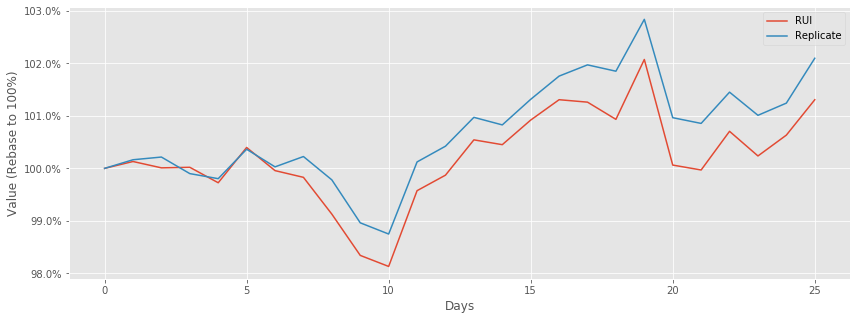

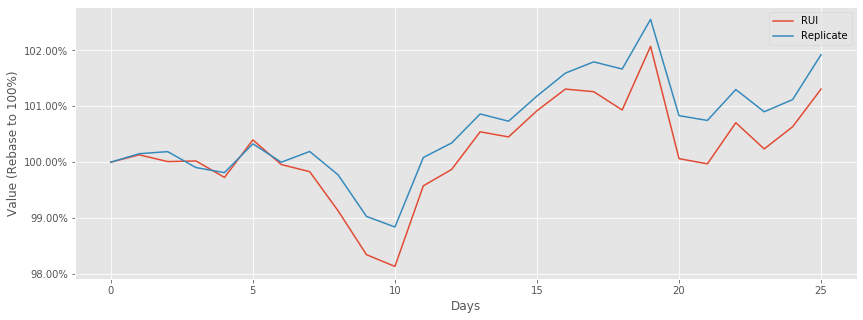

=> The approximation works pretty well


In [13]:
######### Solver error with optimization when fixed shares ##########
# top25_price = top25_data.loc['07-2016':'04-2019', 'Adj Close']
# RUI_price   = index_RUI.loc['07-2016':'04-2019', 'Adj Close']

# Ridge_shares_validation = rolling_validation(estimator=est_Ridge(lambd_value=0.0, constraint_type='both', standardize_flag=False, portfolio_type='shares'),
#                                             Y_data_df=RUI_price[:'03-2019'],
#                                             X_data_df=top25_price[:'03-2019'],
#                                             insample_size=250,
#                                             validation_size=25,
#                                             add_const = False,
#                                             portfolio_type='shares'
#                                             )
######### Solver error with optimization when fixed shares ##########

# Using approximation to transform variable weights (fixed shares) to fixed weights
Ridge_adj_weight_validation = rolling_validation(estimator=est_Ridge(lambd_value=0.0, constraint_type=None, standardize_flag=False),
                                                   Y_data_df=RUI_return[:'03-2019'],
                                                   X_data_df=top25_return[:'03-2019'],
                                                   insample_size=250,
                                                   validation_size=25,
                                                   add_const = False,
                                                   portfolio_type='adjusted_weight',
                                                   YX_price_df_tuple = (index_RUI[['Adj Close']]['07-2016':'03-2019'], top25_data['Adj Close']['07-2016':'03-2019'])
                                                   )

# An instance of rolling_validation with adjusted weight
idx_check = 16
start_date = Ridge_adj_weight_validation[idx_check]['insample-start']
end_date = Ridge_adj_weight_validation[idx_check]['insample-end']
valid_end_date = Ridge_adj_weight_validation[idx_check]['validation-end']
coef_check = Ridge_adj_weight_validation[idx_check]['estimator_fitted'].coef_array

# Fixed shares actual with estimated coefs
myCapital = 1.
myShares = coef_check*myCapital/top25_data.loc[end_date, 'Adj Close']
marketCap_TE_shares = TrackingError_level(index_RUI.loc[end_date:valid_end_date, 'Adj Close'],
                                          top25_data.loc[end_date:valid_end_date, 'Adj Close'].dot(myShares))

print('Error difference :')
print(marketCap_TE_shares.get_TE(print_out=False) - Ridge_adj_weight_validation[idx_check]['validation-result'])
marketCap_TE_shares.get_plot(show=True)
Ridge_adj_weight_validation[idx_check]['validation-TE'].get_plot(show=True)

print('=> The approximation works pretty well')

In [7]:
# Take about 4 mins to run
all_validation_dict = dict()
top25_return = top25_data['Adj Close'].pct_change()['07-2016':'04-2019']
RUI_return   = index_RUI[['Adj Close']].pct_change()['07-2016':'04-2019']
top25_price  = top25_data['Adj Close']['07-2016':'04-2019']
RUI_price    = index_RUI[['Adj Close']]['07-2016':'04-2019']

# L1, L2 loss
lambd_array = np.insert(np.power(3.0, range(-10, 3)), 0, 0.0)
for loss_type, portfolio_type, constraint_type, standardize, lambd in it.product(['l1', 'l2'],
                                                                                 ['weight', 'adjusted_weight'],
                                                                                 ['both', 'sum_1'],
                                                                                 [True, False],
                                                                                 lambd_array):
    all_validation_dict[(loss_type, portfolio_type, constraint_type, standardize, lambd)] = rolling_validation(
                               estimator=est_Ridge(lambd_value=lambd, constraint_type=constraint_type,
                                                   standardize_flag=standardize, loss_type=loss_type, add_const=False),
                               Y_data_df=RUI_return[:'03-2019'],
                               X_data_df=top25_return[:'03-2019'],
                               insample_size=250,
                               validation_size=25,
                               add_const=False,
                               portfolio_type=portfolio_type,
                               YX_price_df_tuple=(RUI_price[:'03-2019'], top25_price[:'03-2019'])
                               )

# CVAR loss
alpha_array = np.arange(0.25, 0.951, 0.1)
for loss_type, portfolio_type, constraint_type, standardize, alpha in it.product(['cvar'],
                                                                                 ['weight', 'adjusted_weight'],
                                                                                 ['both', 'sum_1'],
                                                                                 [False],
                                                                                 alpha_array):
    all_validation_dict[(loss_type, portfolio_type, constraint_type, standardize, alpha)] = rolling_validation(
                               estimator=est_Ridge(constraint_type=constraint_type, standardize_flag=standardize,
                                                   loss_type=loss_type, alpha=alpha, add_const=False),
                               Y_data_df=RUI_return[:'03-2019'],
                               X_data_df=top25_return[:'03-2019'],
                               insample_size=250,
                               validation_size=25,
                               add_const=False,
                               portfolio_type=portfolio_type,
                               YX_price_df_tuple=(RUI_price[:'03-2019'], top25_price[:'03-2019'])
                               )

# Market Cap
for loss_type, portfolio_type, constraint_type, standardize, alpha in it.product(['MarketCap'],
                                                                                 ['weight', 'adjusted_weight'],
                                                                                 ['MarketCap'],
                                                                                 [False],
                                                                                 ['MarketCap']):
    all_validation_dict[(loss_type, portfolio_type, constraint_type, standardize, alpha)] = rolling_validation(
                               estimator=est_MarketCap,
                               Y_data_df=RUI_return[:'03-2019'],
                               X_data_df=top25_return[:'03-2019'],
                               insample_size=250,
                               validation_size=25,
                               add_const=False,
                               portfolio_type=portfolio_type,
                               YX_price_df_tuple=(RUI_price[:'03-2019'], top25_price[:'03-2019']),
                               X_marketcap_df=top25_data.loc['07-2016':'03-2019', 'marketCap']
                               )

In [8]:
# Summary of all validation error
summary_error_dict = dict()
for k in all_validation_dict.keys():
    for idx in all_validation_dict[k].keys():
        summary_error_dict[(*k, idx)] = all_validation_dict[k][idx]['validation-result']
summary_error_df = pd.DataFrame.from_dict(summary_error_dict, orient='index')
summary_error_df.index.rename(['loss', 'portfolio', 'constraint', 'standardize', 'lambda/alpha', 'iter'], inplace=True)
summary_error_df

ETQ  \
loss      portfolio       constraint standardize lambda/alpha iter             
l1        weight          both       True        0.0          0     0.024180   
                                                              1     0.002624   
                                                              2     0.012562   
                                                              3     0.010515   
                                                              4     0.006524   
...                                                                      ...   
MarketCap adjusted_weight MarketCap  False       MarketCap    12    0.005711   
                                                              13    0.010236   
                                                              14    0.002841   
                                                              15    0.009685   
                                                              16    0.016300   

                                                                         MAD  \
loss      portfolio       constraint standardize lambda/alpha iter             
l1        weight          both       True        0.0          0     0.002397   
                                                              1     0.001511   
                                                              2     0.001435   
                                                              3     0.001879   
                                                              4     0.001715   
...                                                                      ...   
MarketCap adjusted_weight MarketCap  False       MarketCap    12    0.004350   
                                                              13    0.003204   
                                                              14    0.002954   
                                                              15    0.002726   
                                                              16    0.001569   

                                                                        RMSE  \
loss      portfolio       constraint standardize lambda/alpha iter             
l1        weight          both       True        0.0          0     0.003384   
                                                              1     0.001910   
                                                              2     0.002194   
                                                              3     0.002288   
                                                              4     0.002611   
...                                                                      ...   
MarketCap adjusted_weight MarketCap  False       MarketCap    12    0.005336   
                                                              13    0.003783   
                                                              14    0.003793   
                                                              15    0.003227   
                                                              16    0.002106   

                                                                       TESTD  
loss      portfolio       constraint standardize lambda/alpha iter            
l1        weight          both       True        0.0          0     0.003166  
                                                              1     0.001891  
                                                              2     0.002070  
                                                              3     0.002115  
                                                              4     0.002537  
...                                                                      ...  
MarketCap adjusted_weight MarketCap  False       MarketCap    12    0.005321  
                                                              13    0.003783  
                                                              14    0.003792  
                                                              15    0.003197  
  

In [9]:
# Convert to rank for relative comparison (High std of validation error make it difficult for inference)
# Seperate group with 2 constraints vs group with only weight sum to 1 constraint
summary_error_df_both = pd.concat([summary_error_df.xs('both', level=2, axis=0), summary_error_df.xs('MarketCap', level=2, axis=0)], axis=0, join='inner')
summary_error_df_sum1 = pd.concat([summary_error_df.xs('sum_1', level=2, axis=0), summary_error_df.xs('MarketCap', level=2, axis=0)], axis=0, join='inner')
summary_rank_df_both = summary_error_df_both.groupby(['iter']).rank()
summary_rank_df_sum1 = summary_error_df_sum1.groupby(['iter']).rank()

In [10]:
# Based on trade-off between rank level vs rank stability. Best model will be the one with highest mean rank across TE measurement

# Group with 2 constraints
temp_df = (summary_rank_df_both.groupby(['loss', 'portfolio', 'standardize', 'lambda/alpha']).mean()/
           summary_rank_df_both.groupby(['loss', 'portfolio', 'standardize', 'lambda/alpha']).std())
# display(temp_df.sort_values(by='ETQ', ascending=False).head())
# display(temp_df.sort_values(by='MAD', ascending=False).head())
# display(temp_df.sort_values(by='RMSE', ascending=False).head())
# display(temp_df.sort_values(by='TESTD', ascending=False).head())
display(temp_df.rank(ascending=False).mean(axis=1).sort_values())

# Group with only weight sum to 1 constraint
temp_df = (summary_rank_df_sum1.groupby(['loss', 'portfolio', 'standardize', 'lambda/alpha']).mean()/
           summary_rank_df_sum1.groupby(['loss', 'portfolio', 'standardize', 'lambda/alpha']).std())
# display(temp_df.sort_values(by='ETQ', ascending=False).head(10))
# display(temp_df.sort_values(by='MAD', ascending=False).head(10))
# display(temp_df.sort_values(by='RMSE', ascending=False).head(10))
# display(temp_df.sort_values(by='TESTD', ascending=False).head(10))
display(temp_df.rank(ascending=False).mean(axis=1).sort_values())

loss  portfolio  standardize  lambda/alpha
l2    weight     True         0.000000          1.50
                              0.000017          2.25
                              0.000051          2.50
                              0.000152          3.75
                              0.000457          5.00
                                               ...  
                 False        0.037037        117.50
                              1.000000        117.75
                              0.111111        118.00
cvar  weight     False        0.950000        118.25
l2    weight     False        0.333333        119.00
Length: 130, dtype: float64

loss  portfolio        standardize  lambda/alpha
l2    adjusted_weight  True         0.004115          8.00
                                    0.000457          8.25
                                    0.001372          8.50
                                    0.111111          9.50
                                    0.000152          9.50
                                                     ...  
      weight           False        9.000000        115.50
                                    1.000000        115.75
                                    0.111111        116.75
                                    0.333333        116.75
                                    0.037037        117.50
Length: 130, dtype: float64

In [11]:
final_models_dict = dict()

final_models_dict['both'] = rolling_validation(
                                               estimator=est_Ridge(lambd_value=0.0, constraint_type='both',
                                                                   standardize_flag=True, loss_type='l2', add_const=False),
                                               Y_data_df=RUI_return[:'04-2019'],
                                               X_data_df=top25_return[:'04-2019'],
                                               insample_size=250,
                                               validation_size=21,
                                               add_const=False,
                                               portfolio_type='weight',
                                               YX_price_df_tuple=(RUI_price[:'04-2019'], top25_price[:'04-2019'])
                                               )

final_models_dict['sum_1'] = rolling_validation(
                                               estimator=est_Ridge(lambd_value=0.004115, constraint_type='sum_1',
                                                                   standardize_flag=True, loss_type='l2', add_const=False),
                                               Y_data_df=RUI_return[:'04-2019'],
                                               X_data_df=top25_return[:'04-2019'],
                                               insample_size=250,
                                               validation_size=21,
                                               add_const=False,
                                               portfolio_type='adjusted_weight',
                                               YX_price_df_tuple=(RUI_price[:'04-2019'], top25_price[:'04-2019'])
                                               )

Test date start: 2019-03-29 00:00:00
Test date end: 2019-04-30 00:00:00
Test Tracking Error:
ETQ      0.004161
MAD      0.002564
RMSE     0.003245
TESTD    0.003241
dtype: float64


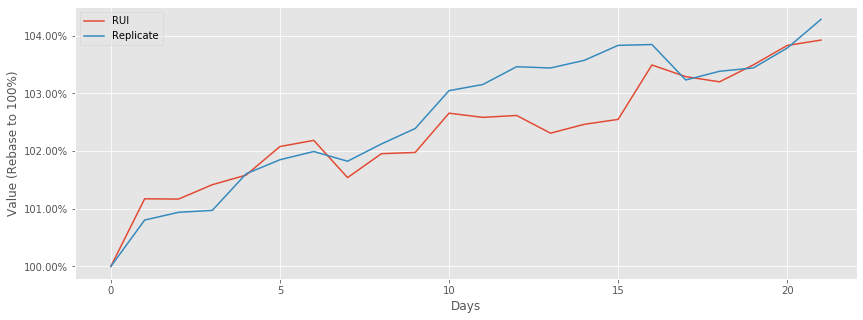

Test date start: 2019-03-29 00:00:00
Test date end: 2019-04-30 00:00:00
Test Tracking Error:
ETQ      0.006359
MAD      0.003247
RMSE     0.004283
TESTD    0.004193
dtype: float64


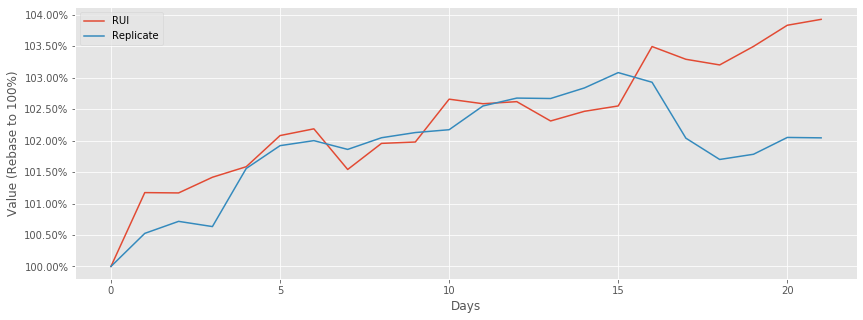

In [12]:
for k in ['both', 'sum_1']:
    last_idx = sorted(final_models_dict[k].keys())[-1]
    print('Test date start:', final_models_dict[k][last_idx]['insample-end'])
    print('Test date end:', final_models_dict[k][last_idx]['validation-end'])
    print('Test Tracking Error:')
    final_models_dict[k][last_idx]['validation-TE'].get_TE(print_out=True)
    final_models_dict[k][last_idx]['validation-TE'].get_plot(show=True)

ETQ      0.006342
MAD      0.002237
RMSE     0.002901
TESTD    0.002883
dtype: float64


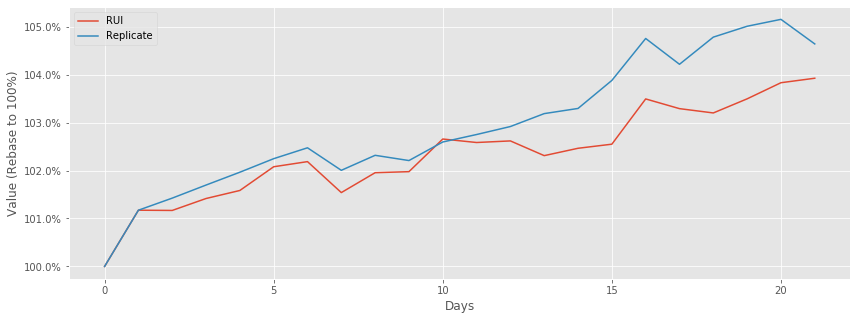

ETQ      0.006610
MAD      0.002281
RMSE     0.002991
TESTD    0.002973
dtype: float64


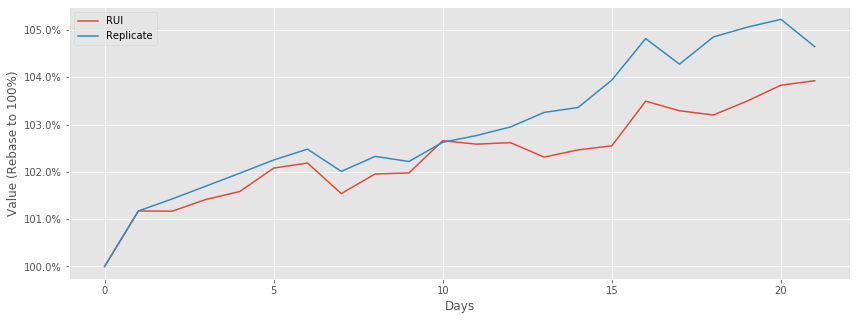

In [14]:
### Fixed weight
# Not using freefloat due to lack of reliable freefloat data
marketCap_Mar_EOP = top25_data.loc['03-29-2019', 'marketCap']
marketCap_weight = marketCap_Mar_EOP/marketCap_Mar_EOP.sum()

marketCap_return = top25_return['04-2019'].dot(marketCap_weight)
actual_return = RUI_return['04-2019']

marketCap_TE_weight = TrackingError(actual_return, marketCap_return)
# assert np.allclose(marketCap_TE_weight.get_level()[0],
#                    (index_RUI['Adj Close']['29-03-2019':'04-2019']/index_RUI['Adj Close']['29-03-2019']).values)

marketCap_TE_weight.get_TE(print_out=True)
marketCap_TE_weight.get_plot(show=True)

### Fixed shares
myCapital = 1.0
myShares = marketCap_weight*myCapital/top25_data.loc['03-29-2019', 'Adj Close']
marketCap_TE_shares = TrackingError_level(index_RUI.loc['03-29-2019':'04-2019', 'Adj Close'],
                                          top25_data.loc['03-29-2019':'04-2019', 'Adj Close'].dot(myShares))

# assert (np.allclose(marketCap_TE_shares.get_level()[1] * myCapital, top25_data.loc['03-29-2019':'04-2019', 'Adj Close'].dot(myShares)))
# assert (np.allclose(marketCap_TE_shares.get_level()[0] * index_RUI.loc['03-29-2019', 'Adj Close'],
#                     index_RUI['Adj Close']['03-29-2019':'04-2019'].values))

marketCap_TE_shares.get_TE(print_out=True)
marketCap_TE_shares.get_plot(show=True)